[[0.    0.144 0.192 0.288 0.384 0.432 0.576]
 [0.    0.072 0.    0.144 0.    0.072 0.   ]]



[[0.16099689]
 [0.16099689]
 [0.16099689]
 [0.16099689]
 [0.08653323]
 [0.17306646]
 [0.17306646]
 [0.08653323]
 [0.192     ]
 [0.192     ]
 [0.192     ]]


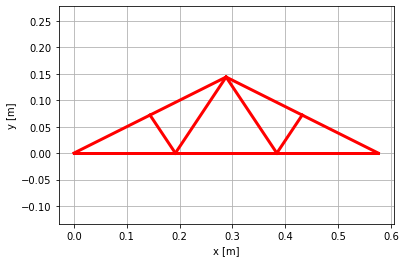

[[0.    0.144 0.192 0.288 0.384 0.432 0.576]
 [0.    0.072 0.    0.144 0.    0.072 0.   ]]



[[0.16099689]
 [0.16099689]
 [0.16099689]
 [0.16099689]
 [0.08653323]
 [0.17306646]
 [0.17306646]
 [0.08653323]
 [0.192     ]
 [0.192     ]
 [0.192     ]]
[[0.16099689]
 [0.16099689]
 [0.16099689]
 [0.16099689]
 [0.08653323]
 [0.17306646]
 [0.17306646]
 [0.08653323]
 [0.192     ]
 [0.192     ]
 [0.192     ]]


In [1]:
from funcoesTermosol import importa, plota, geraSaida, gauss_seidel
import numpy as np

[nn,N,nm,Inc,nc,F,nr,R, L, angle] = importa('entrada2.xlsx')
print(L)
geraSaida('teste',F,F,F,F,F)

In [2]:
# Define a matriz de rigidez local para cada barra
K = []
nos = np.zeros((nm,2))
for i in range(nm):
    E = Inc[i,2]
    A = Inc[i,3]
    Li = L[i][0]
    theta = angle[i,0]

    nos[i,0] = Inc[i,0]
    nos[i,1] = Inc[i,1]

    K1 = np.zeros((4,4), dtype=float)

    K1[0,0] = (E*A/Li)*np.cos(theta)**2
    K1[0,1] = (E*A/Li)*np.cos(theta)*np.sin(theta)
    K1[0,2] = -(E*A/Li)*np.cos(theta)**2
    K1[0,3] = -(E*A/Li)*np.cos(theta)*np.sin(theta)

    K1[1,0] = (E*A/Li)*np.cos(theta)*np.sin(theta)
    K1[1,1] = (E*A/Li)*np.sin(theta)**2
    K1[1,2] = -(E*A/Li)*np.cos(theta)*np.sin(theta)
    K1[1,3] = -(E*A/Li)*np.sin(theta)**2

    K1[2,0] = -(E*A/Li)*np.cos(theta)**2
    K1[2,1] = -(E*A/Li)*np.cos(theta)*np.sin(theta)
    K1[2,2] = (E*A/Li)*np.cos(theta)**2
    K1[2,3] = (E*A/Li)*np.cos(theta)*np.sin(theta)

    K1[3,0] = -(E*A/Li)*np.cos(theta)*np.sin(theta)
    K1[3,1] = -(E*A/Li)*np.sin(theta)**2
    K1[3,2] = (E*A/Li)*np.cos(theta)*np.sin(theta)
    K1[3,3] = (E*A/Li)*np.sin(theta)**2
    K.append(K1)

# if a number in K is between -1e-8 and 1e-8, it is considered 0
for i in range(nn):
    for j in range(4):
        for k in range(4):
            if K[i][j,k] < 1e-8 and K[i][j,k] > -1e-8:
                K[i][j,k] = 0


# Define a matriz global de rigidez
KG = np.zeros((nn*2,nn*2))

for count, matrizLocal in enumerate(K):
    n = nos[count]
    m1 = int(n[0])
    m2 = int(n[1])
    KG[np.ix_([(m1 - 1)*2, (m1 - 1)*2+1, (m2 - 1)*2, (m2 - 1)*2+1], [(m1 - 1)*2, (m1 - 1)*2+1, (m2 - 1)*2, (m2 - 1)*2+1])] += matrizLocal[0:4,0:4]

KGoriginal = KG.copy()

for r in R:
    KG[int(r[0]-1)*2  + (int(r[1]) - 1), :] = 0
    KG[:, int(r[0]-1)*2  + (int(r[1]) - 1)] = 0

# KGfinal = KG[np.ix_([1,4,5],[1,4,5])]
notzero = np.arange(0,nn*2)
for i in range(len(R)):
    if (R[i,0]-1)*2 + (R[i,1] - 1) in notzero:
        notzero = np.delete(notzero, np.where(notzero == (R[i,0]-1)*2 + (R[i,1] - 1)))

KGfinal = KG[np.ix_(notzero,notzero)]

fglobal = F.copy()
fglobal  = fglobal[np.ix_(notzero)]


In [3]:
# K x u = F

u = np.zeros((len(notzero),1))

x = gauss_seidel(KGfinal, fglobal, u, 1e-10, 10000)

utotal = np.zeros((nn*2,1))
for i in range(len(notzero)):
    utotal[notzero[i]] = x[i]

print(utotal)

[[ 0.        ]
 [ 0.        ]
 [ 0.00100461]
 [-0.00431138]
 [ 0.0003597 ]
 [-0.00466275]
 [ 0.00025966]
 [-0.00443891]
 [ 0.00055848]
 [-0.00463723]
 [-0.00032433]
 [-0.00424746]
 [ 0.00116435]
 [ 0.        ]]


In [4]:
# Deformação específica em cada elemento 
defEsp = np.zeros((nm,1))
for i in range(nm):
    E = Inc[i,2]
    A = Inc[i,3]
    Li = L[i][0]
    theta = angle[i,0]

    defEsp[i] = (1/Li)*np.matmul(np.array([-np.cos(theta), -np.sin(theta), np.cos(theta), np.sin(theta)]), 
                                 np.array([utotal[int(nos[i,0])*2 - 2], utotal[int(nos[i,0])*2 - 1], utotal[int(nos[i,1])*2 - 2], utotal[int(nos[i,1])*2 - 1]]))

defEsp

array([[-0.00639489],
       [-0.0044929 ],
       [-0.00377618],
       [-0.00352806],
       [-0.00075551],
       [ 0.00075547],
       [ 0.00191118],
       [-0.00191126],
       [ 0.00187345],
       [ 0.00103528],
       [ 0.0031556 ]])

In [5]:
# Tensão em cada elemento

tensao = np.zeros((nm,1))
for i in range(nm):
    E = Inc[i,2]
    A = Inc[i,3]
    Li = L[i][0]
    theta = angle[i,0]

    tensao[i] = E*defEsp[i]

tensao

array([[-1.23510889e+09],
       [-8.67758062e+08],
       [-7.29330853e+08],
       [-6.81410012e+08],
       [-1.45918734e+08],
       [ 1.45911330e+08],
       [ 3.69126185e+08],
       [-3.69140042e+08],
       [ 3.61838199e+08],
       [ 1.99953745e+08],
       [ 6.09471643e+08]])

In [6]:
# Reações de apoio
reacoes = np.zeros((nm,1))
reacoes = np.matmul(KGoriginal,utotal) 
print(reacoes)
reacoesApoio = np.zeros((len(R),1))
i = 0
for r in R:
    print(reacoes[int(r[0]-1)*2 + (int(r[1]) - 1)])
    reacoesApoio[i] = reacoes[int(r[0]-1)*2 + (int(r[1]) - 1)]
    i += 1

reacoesApoio

[[ 3.90010306e+03]
 [ 2.89987680e+03]
 [-1.30004394e+03]
 [-1.49990405e+03]
 [ 3.28658774e-02]
 [ 3.23432888e-02]
 [-1.30005951e+03]
 [-1.49993949e+03]
 [-7.75812220e-03]
 [ 6.05274372e-02]
 [-1.30002472e+03]
 [-1.49998920e+03]
 [ 0.00000000e+00]
 [ 1.59986306e+03]]
[3900.10306378]
[2899.87680356]
[1599.86306373]


array([[3900.10306378],
       [2899.87680356],
       [1599.86306373]])

In [7]:
# Força interna em cada barra
forcaInterna = np.zeros((nm,1))
for i in range(nm):
    A = Inc[i,3]
    
    forcaInterna[i] = tensao[i]*A

forcaInterna

array([[-6484.32165913],
       [-4555.72982534],
       [-3828.98698068],
       [-3577.40256519],
       [ -766.07335498],
       [  766.03448319],
       [ 1937.91247358],
       [-1937.9852185 ],
       [ 1899.65054334],
       [ 1049.75715899],
       [ 3199.72612746]])

In [8]:
geraSaida("saida", reacoesApoio, utotal, defEsp, forcaInterna, tensao)